In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(os.getenv('PYTHONPATH')) 
import warnings
warnings.filterwarnings('ignore')
import pickle

#third party
import numpy as np
import hcp_utils as hcp
import matplotlib.pyplot as plt
from nilearn import plotting
from scipy import stats

#local
from src.utils.helpers import calculate_noiseceiling

In [ ]:
#define subject and session
subject=1
session=1

#setup paths
datasets_root = os.path.join(os.getenv("DATASETS_ROOT", "/default/path/to/datasets")) #use default if DATASETS_ROOT env variable is not set.
dataset_root = os.path.join(datasets_root, "NaturalScenesDataset")
meta_dataset_root = os.path.join(datasets_root, "MOSAIC")
project_root = os.getenv("PROJECT_ROOT", "/default/path/to/datasets")
print(f"dataset_root: {dataset_root}")
print(f"project_root: {project_root}")
fmri_path = os.path.join(dataset_root,"derivatives", "GLM")

save_root = os.path.join(project_root, "fmriDatasetPreparation", "NaturalScenesDataset", "validation", "output_noiseceiling")

if not os.path.exists(save_root):
    os.makedirs(save_root)

In [6]:
fmri_data = np.load(os.path.join(dataset_root, "derivatives", "GLM", f"sub-{subject:02}", f"ses-nsd{session:02}", "TYPED_FITHRF_GLMDENOISE_RR.npy"), allow_pickle=True).item() 
fmri_data = fmri_data['betasmd'].squeeze() #shape nvertices, ntrials
designinfo = np.load(os.path.join(dataset_root, "derivatives", "GLM", f"sub-{subject:02}", f"ses-nsd{session:02}", "DESIGNINFO.npy"), allow_pickle=True).item()
with open(os.path.join(dataset_root, "derivatives", "GLM", f"sub-{subject:02}", f"ses-nsd{session:02}", f"sub-{subject:02}_ses-nsd{session:02}_task-nsdcore_conditionOrderDM.pkl"), 'rb') as f:
    run_design, stim_unique = pickle.load(f)
nvertices = fmri_data.shape[0]

In [7]:
#find the stimuli with three repetitions 
numreps = 3
repeated_stim_indices = np.argwhere(np.array(designinfo['condcounts']) == numreps) #the index is the index from 0 to number of unique stimuli in session (583 for sub 01 session 1), not the string of stimulus ID
betas = np.zeros((nvertices, numreps, len(repeated_stim_indices)))
for count, idx in enumerate(repeated_stim_indices):
    betas[:,:,count] = fmri_data[:, designinfo['stimorder'] == idx]
print(f"betas.shape: {betas.shape}")

betas.shape: (91282, 3, 31)


In [25]:
ncsnr, noiseceiling = calculate_noiseceiling(betas, n=3)
print(np.nanmax(noiseceiling))

92.06159493392133


In [45]:
betas_z = stats.zscore(betas, axis=2, ddof=1, nan_policy='propagate')
betas_z.shape

(91282, 3, 31)

In [46]:
np.mean(betas_z[20000,:,:])

-1.850371707708594e-17

In [47]:
ncsnr, noiseceiling_z = calculate_noiseceiling(betas_z, n=3)
print(np.nanmax(noiseceiling_z))

94.34750079011141


In [48]:
(noiseceiling == noiseceiling_z).sum()

37155

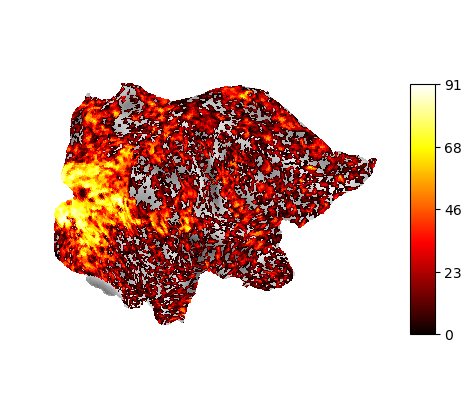

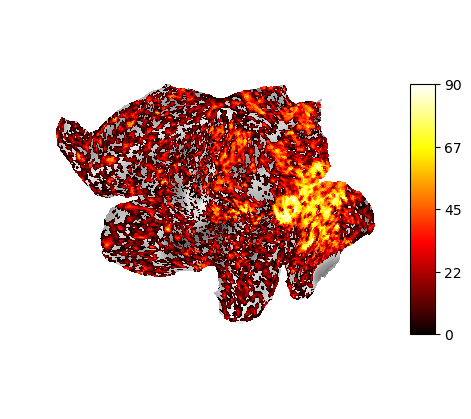

In [49]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
noiseceiling[noiseceiling < 0] = 0
stat = noiseceiling.copy()
for hemi in ['left','right']:

    #mesh = hcp.mesh.inflated
    #cortex_data = hcp.cortex_data(stat)
    #bg = hcp.mesh.sulc
    #for view in views:
    #    display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
    #    threshold=0, bg_map=bg, view=view, cmap='hot')
    #    plt.show()

    #flattened brain
    if hemi == 'left':
        cortex_data = hcp.left_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot')
        plt.show()
    if hemi == 'right':
        cortex_data = hcp.right_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot')
        plt.show()

19.412652118977377
-38.52916511470606


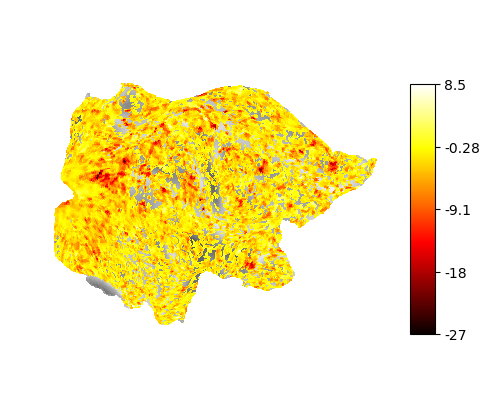

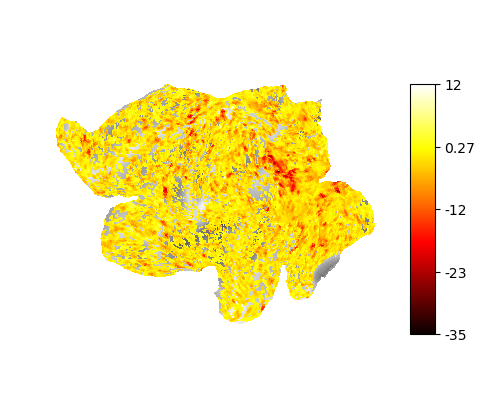

In [50]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
noiseceiling_diff = noiseceiling - noiseceiling_z 
stat = noiseceiling_diff
print(np.nanmax(stat))
print(np.nanmin(stat))
for hemi in ['left','right']:

    #mesh = hcp.mesh.inflated
    #cortex_data = hcp.cortex_data(stat)
    #bg = hcp.mesh.sulc
    #for view in views:
    #    display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
    #    threshold=0, bg_map=bg, view=view, cmap='hot')
    #    plt.show()

    #flattened brain
    if hemi == 'left':
        cortex_data = hcp.left_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot')
        plt.show()
    if hemi == 'right':
        cortex_data = hcp.right_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot')
        plt.show()